In [1]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import numpy as np
import sys

G = 9.81

FDSN_CLIENT = Client("http://192.168.11.250:8080")

NETWORK = "GO"
STATION = "EMLK"
CHANNEL_ACC = "HN*"
CHANNEL_VEL = "HH*"

# გამოყენება: python pga_calc.py "2024-07-22T08:08:09.660"
if len(sys.argv) > 1:
    origin_time_str = sys.argv[1]
else:
    origin_time_str = "2024-07-22T08:08:09.660"  # fallback/hardcode

ORIGIN_TIME = UTCDateTime("2025-03-08 11:28:25.120")
START_TIME = ORIGIN_TIME - 120
END_TIME = ORIGIN_TIME + 180

In [2]:
# --------------------------
# 1) პირდაპირი ACC არხებიდან
# --------------------------
acc_inventory = FDSN_CLIENT.get_stations(
    network=NETWORK,
    station=STATION,
    location="*",
    channel=CHANNEL_ACC,
    starttime=START_TIME,
    endtime=END_TIME,
    level="response"
)

acc_stream = FDSN_CLIENT.get_waveforms(
    NETWORK, STATION, "*", CHANNEL_ACC, START_TIME, END_TIME
)

acc_stream.remove_response(
    inventory=acc_inventory,
    output="ACC",
    pre_filt=[0.1, 0.2, 30.0, 40.0],
    zero_mean=True,
    water_level=0.0
)

acc_stream.filter(
    "bandpass",
    freqmin=1,
    freqmax=10.0,
    corners=4,
    zerophase=True,
)

print("=== PGA from ACC channels (HN*) ===")
for tr in acc_stream:
    g_acc = tr.data / G
    max_g = np.max(np.abs(g_acc))
    pga_percent = max_g * 100   # %g
    print(f"{tr.id} : {max_g:.6f} g  PGA: ({pga_percent:.2f} %g)")

=== PGA from ACC channels (HN*) ===
GO.EMLK.20.HNE : 0.000074 g  PGA: (0.01 %g)
GO.EMLK.20.HNN : 0.000063 g  PGA: (0.01 %g)
GO.EMLK.20.HNZ : 0.000043 g  PGA: (0.00 %g)


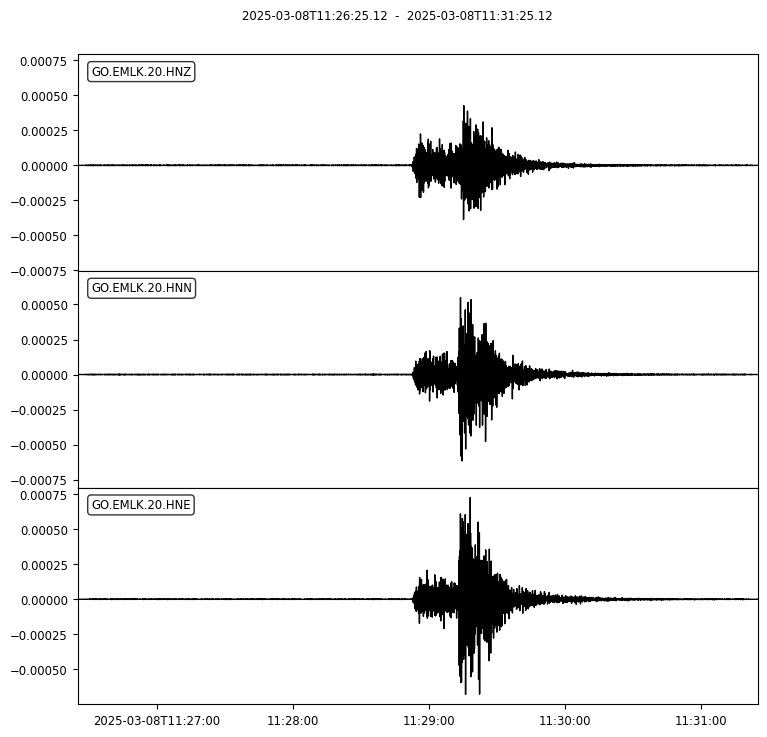

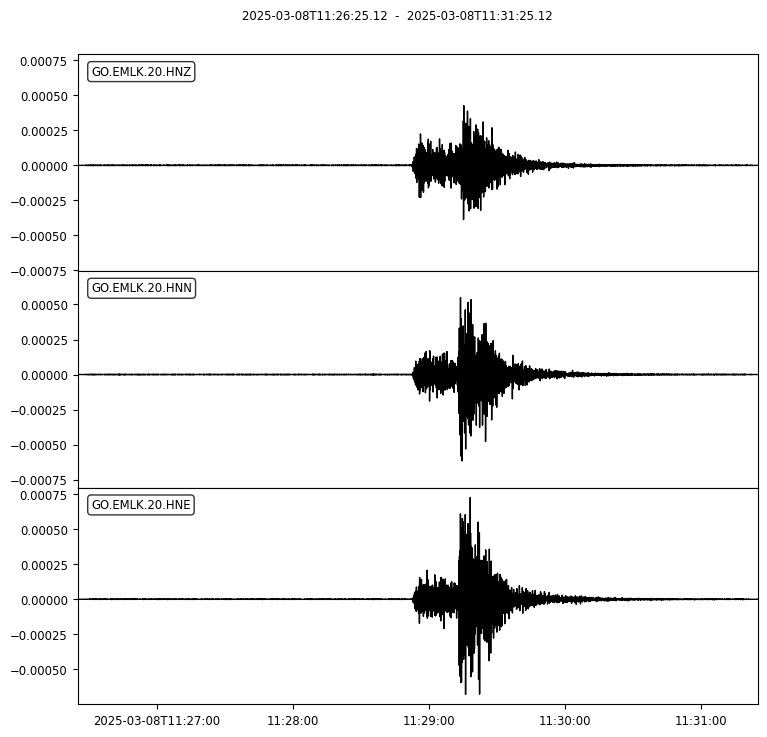

In [3]:
# 👉 აქვე ვხატავთ ACC არხებს ( უკვე response-გადახდილი + გაფილტრული )
acc_stream.plot(equal_scale=True)

In [4]:
# --------------------------
# 2) VEL არხებიდან დიფერენცირებით
# --------------------------
vel_inventory = FDSN_CLIENT.get_stations(
    network=NETWORK,
    station=STATION,
    location="*",
    channel=CHANNEL_VEL,
    starttime=START_TIME,
    endtime=END_TIME,
    level="response"
)

vel_stream = FDSN_CLIENT.get_waveforms(
    NETWORK, STATION, "*", CHANNEL_VEL, START_TIME, END_TIME
)

vel_stream.remove_response(
    inventory=vel_inventory,
    output="VEL",
    pre_filt=[0.1, 0.2, 30.0, 40.0],
    zero_mean=True,
    water_level=0.0
)

vel_stream.filter("bandpass", freqmin=1, freqmax=10.0, corners=4, zerophase=True)

# ვაკეთებთ ACC ვერსიას – ცალკე Stream
vel_acc_stream = vel_stream.copy()
for tr in vel_acc_stream:
    tr.differentiate()  # ახლა ეს უკვე ACC (m/s²)-ია

# აქედან ვთვლით PGA-ს
for tr in vel_acc_stream:
    max_acc = np.max(np.abs(tr.data))
    max_g = max_acc / G
    pga_percent = max_g * 100
    print(f"{tr.id} -> PGA: {max_g:.6f} g ({pga_percent:.2f} %g)")

GO.EMLK.00.HHE -> PGA: 0.000151 g (0.02 %g)
GO.EMLK.00.HHN -> PGA: 0.000123 g (0.01 %g)
GO.EMLK.00.HHZ -> PGA: 0.000088 g (0.01 %g)


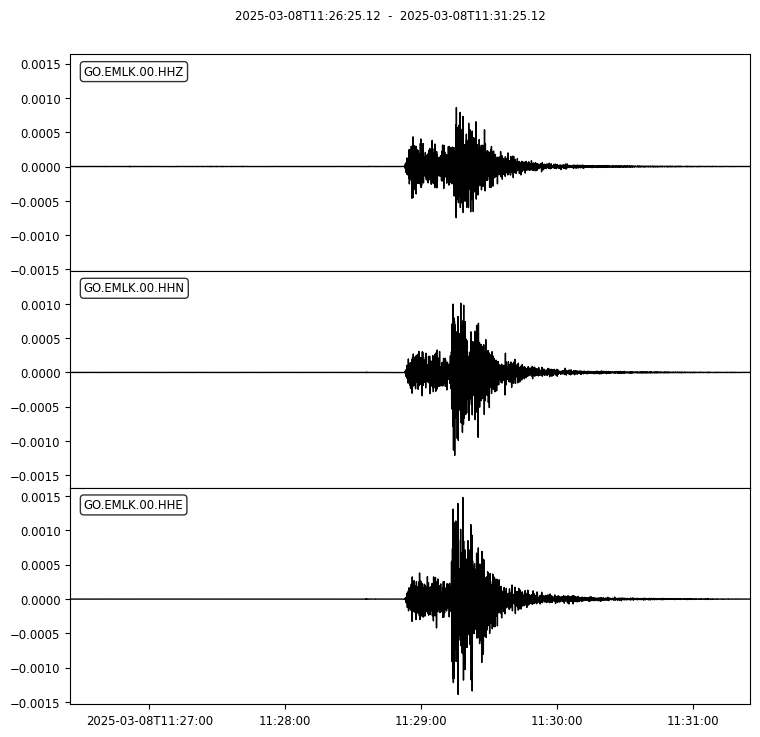

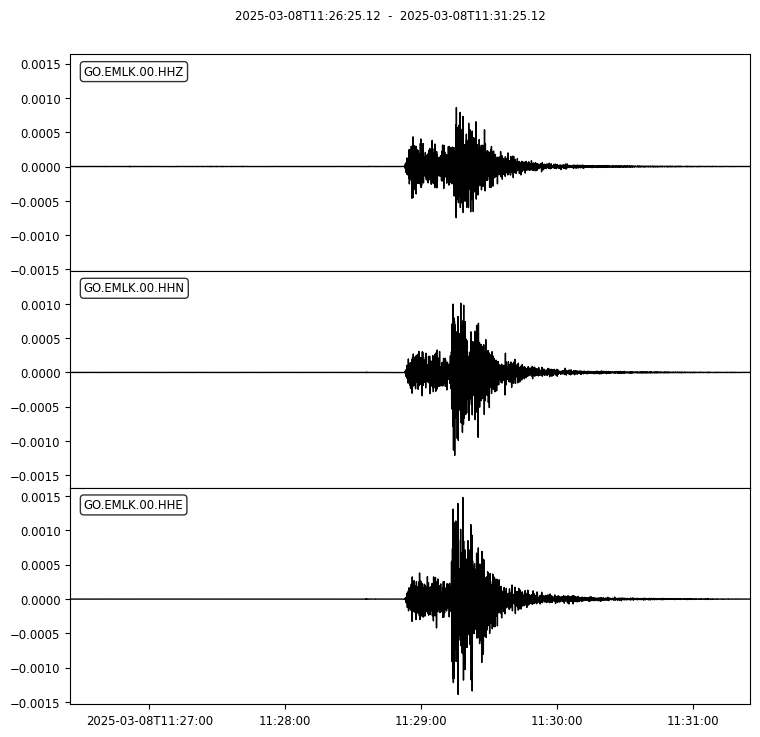

In [5]:
# 👉 და ესენი – VEL→ACC დიფერენცირებული სიგნალები
vel_acc_stream.plot(equal_scale=True)

In [6]:
# ვიგონებთ vel_acc_stream-ს ACC-სთვის (ერთი დიფერენცირება)
vel_acc_stream = vel_stream.copy()
for tr in vel_acc_stream:
    tr.differentiate()   # აქ ერთხელ და მორჩა

# ახლა cross_correlation:
from obspy.signal.cross_correlation import correlate, xcorr_max

tr_acc     = acc_stream.select(channel="HNZ")[0]       # რეალური ACC
tr_vel_acc = vel_acc_stream.select(channel="HHZ")[0]   # VEL→ACC

# დროის გასწორება
t_start = max(tr_acc.stats.starttime, tr_vel_acc.stats.starttime)
t_end   = min(tr_acc.stats.endtime, tr_vel_acc.stats.endtime)

tr_acc_aligned     = tr_acc.copy().trim(t_start, t_end, pad=True, fill_value=0)
tr_vel_acc_aligned = tr_vel_acc.copy().trim(t_start, t_end, pad=True, fill_value=0)

npts = min(tr_acc_aligned.stats.npts, tr_vel_acc_aligned.stats.npts)
sig1 = tr_acc_aligned.data[:npts]
sig2 = tr_vel_acc_aligned.data[:npts]

max_shift_seconds  = 10
max_shift_samples  = int(max_shift_seconds * tr_acc.stats.sampling_rate)

cc = correlate(sig1, sig2, shift=max_shift_samples)
shift, value = xcorr_max(cc)

print(f"Max correlation value: {value:.3f}")
print(f"Time shift: {shift * tr_acc.stats.delta:.6f} s")

Max correlation value: 0.006
Time shift: 5.510000 s
